# Synthetic Sonic Log Generation -- Rocket Team

## 1. Import
### 1.1. Import libraries with seeds
Random_state and seed are set up for all the libriaries and steps that involves randomization in the model. Even though, the prediction results might not be 100% reproducible (up to 3% difference), as some functions of Keras and TensorFlow are not deterministic.

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(12)
import random as rn
rn.seed(123)
import tensorflow as tf
tf.set_random_seed(1234)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
import tensorflow.python.keras.backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

### 1.2. Import other libraries

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, Dense, Dropout, LSTM
from keras.models import Sequential
from keras import initializers
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 2. Read Data
Missing values (values equals to -999), whether they're from features or from targets, were dropped. The caliper (CAL) measures the borehole diameter and is physically irrelevant to travel times of commpressional waves and shear waves. Thus, this feature was dropped before building the model. Extremely high values of neutron (CNC > 40) are regarded as data outliers, and they were dropped to make the training data cleaner.
- CAL - Caliper, unit in Inch
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter
- HRM - Medium Resistivity, unit in Ohm per meter
- PE - Photo-electric Factor, unit in Barn
- ZDEN - Density, unit in Gram per cubit meter
- DTC - Compressional Travel-time, unit in nanosecond per foot
- DTS - Shear Travel-time, unit in nanosecond per foot

In [3]:
# read data
df_raw = pd.read_csv('train.csv')
print('Raw training data')
display(df_raw)

# data cleaning
df_cln = df_raw.replace(['-999', -999], np.nan)
df_cln.dropna(inplace=True)

# feature selection
df_cln.drop(['CAL'], axis=1, inplace=True)

# discard outlier
df_cln = df_cln.drop(df_cln[df_cln.CNC > 40].index)
print('Cleaned training data')
display(df_cln)

# train
X_train = df_cln.drop(['DTC', 'DTS'], axis=1)
y_train = df_cln[['DTC', 'DTS']].values

Raw training data


,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,-999.0000,-999.0000,41.4699,-999.0000,-999.0000,-999.0000,-999.0000,128.0737,319.0654
1,-999.0000,-999.0000,42.5053,-999.0000,-999.0000,-999.0000,-999.0000,127.8347,318.7825
2,-999.0000,-999.0000,43.1548,-999.0000,-999.0000,-999.0000,-999.0000,127.2307,317.3323
3,-999.0000,-999.0000,43.2410,-999.0000,-999.0000,-999.0000,-999.0000,126.2917,313.6486
4,-999.0000,-999.0000,40.3218,-999.0000,-999.0000,-999.0000,-999.0000,125.3985,307.8903
...,...,...,...,...,...,...,...,...,...
30138,8.6719,0.1879,119.9486,2.5130,2.5187,0.0597,2.6240,74.2133,131.7747
30139,8.6719,0.1825,122.5286,2.5011,2.4818,0.0582,2.6194,74.3503,132.2201
30140,8.6797,0.1774,122.0544,2.5010,2.4717,0.0571,2.6169,74.4752,132.5171
30141,8.6719,0.1744,120.6518,2.5150,2.5007,0.0562,2.6159,74.5917,132.7115


Cleaned training data


,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
573,0.5173,57.1903,1.9826,1.9726,27.9432,2.3510,125.9611,306.8676
574,0.4966,63.1593,2.0472,1.6373,28.1064,2.4055,125.9726,305.8347
575,0.4433,64.5217,2.0464,1.4866,26.5968,2.4579,125.8528,305.9089
576,0.4309,63.0144,2.0054,1.4613,19.5635,2.4219,125.7362,305.1737
577,0.4469,60.8421,1.9533,1.4438,9.8556,2.3138,125.9774,304.4476
...,...,...,...,...,...,...,...,...
30138,0.1879,119.9486,2.5130,2.5187,0.0597,2.6240,74.2133,131.7747
30139,0.1825,122.5286,2.5011,2.4818,0.0582,2.6194,74.3503,132.2201
30140,0.1774,122.0544,2.5010,2.4717,0.0571,2.6169,74.4752,132.5171
30141,0.1744,120.6518,2.5150,2.5007,0.0562,2.6159,74.5917,132.7115


## 3. Build Model
Machine learning algorithms, such as support vector machine, random forest and XGBoost, only produce a point-to-point mapping from input features to targets. However, well logs often demonstrate a trend with depths at a specific location, because sequence strata were deposited continously most of times at a region (Pham & Wu, 2019). Long short-term memory (LSTM) is a type of recurrent neural network (RNN) whose output is not only determined by the input from current step but also the input from previous steps (Chen & Zhang, 2020). Here, a bidirectional LSTM is selected because it considers both overlying and underlying steps when predicting for the current steps.
Different parameters have been tested, including number of layers, number neurons, batch size, and epochs. By the earlystopping, the training process will be stopped once the loss is no longer decreasing.

In [4]:
start = time()

# reshape
n_features = X_train.shape[1]
X_train = X_train.values.reshape((X_train.shape[0], 1, n_features))

# initialize weights
kernel_initializer = initializers.glorot_uniform(seed=0)
recurrent_initializer = initializers.Orthogonal(gain=1.0, seed=0)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(1, n_features), kernel_initializer=kernel_initializer,
                            recurrent_initializer=recurrent_initializer, bias_initializer='zeros')))
model.add(Dropout(0.5, seed=0))
model.add(Dense(2, kernel_initializer=kernel_initializer, bias_initializer='zeros', activation='linear'))
model.compile(optimizer='adam', loss='mse', seed=0)

# fit model
np.random.seed(12)
rn.seed(123)
earlystopper = EarlyStopping(monitor='loss', mode='min')
model.fit(X_train, y_train, batch_size=16, epochs=30, callbacks=[earlystopper])

end = time()
runtime = str(datetime.timedelta(seconds=int(end-start)))
print('Runtime: ' + runtime)

Epoch 1/30
20522/20522 [==============================] - 7s 364us/step - loss: 11967.1448
Epoch 2/30
20522/20522 [==============================] - 7s 332us/step - loss: 4559.9649
Epoch 3/30
20522/20522 [==============================] - 7s 332us/step - loss: 2765.7655
Epoch 4/30
20522/20522 [==============================] - 7s 322us/step - loss: 2028.8431
Epoch 5/30
20522/20522 [==============================] - 7s 326us/step - loss: 1580.2552
Epoch 6/30
20522/20522 [==============================] - 7s 319us/step - loss: 1241.8913
Epoch 7/30
20522/20522 [==============================] - 7s 323us/step - loss: 1030.6854
Epoch 8/30
20522/20522 [==============================] - 7s 334us/step - loss: 850.2823
Epoch 9/30
20522/20522 [==============================] - 6s 312us/step - loss: 739.6748
Epoch 10/30
20522/20522 [==============================] - 6s 304us/step - loss: 649.7052
Epoch 11/30
20522/20522 [==============================] - 6s 313us/step - loss: 617.1585
Epoch 12/30

## 4. Check Results
Overall, the predicted curves of DTC and DTS are quite close to their true curves, except for some points where the predicted curves exhibit strong fluctuations while the true curves are more smooth. These fluctuations are are the major sources of prediction errors and are usually very difficult to predict.

Training set RMSE 16.1462


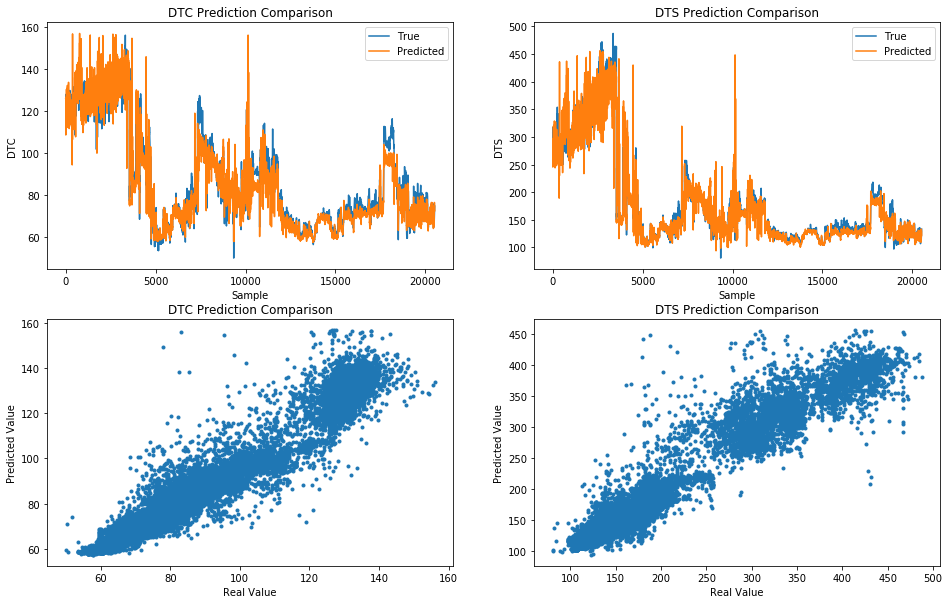

In [5]:
def result_plot(y_predict, y_real):
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.plot(y_real[:, 0], y_predict[:, 0], '.')
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.plot(y_real[:, 1], y_predict[:, 1], '.')
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

# check the accuracy of predicted data
p_train = model.predict(X_train)

rmse_train = np.sqrt(np.square(np.subtract(y_train, p_train)).mean())
print('Training set RMSE {:.4f}'.format(rmse_train))

# plot results
result_plot(p_train, y_train)

## 5. Prediction
The strategy of feature selection, which has been applied to the training dataset, is applied to the testing dataset. 

Raw testing data


,CAL,CNC,GR,HRD,HRM,PE,ZDEN
0,8.5781,0.3521,55.1824,0.8121,0.7810,6.8291,2.3256
1,8.5781,0.3639,57.0114,0.8038,0.7723,6.8100,2.3255
2,8.5781,0.3703,58.9263,0.7444,0.7048,6.7766,2.3212
3,8.5625,0.3667,57.3308,0.7169,0.6542,6.7219,2.3119
4,8.5781,0.3500,53.0624,0.6845,0.6109,6.6384,2.2982
...,...,...,...,...,...,...,...
11083,8.7813,0.1882,68.0333,1.0280,0.9815,6.5003,2.4423
11084,8.7344,0.1879,68.0753,1.0249,0.9822,6.4415,2.4377
11085,8.7266,0.1824,68.8516,1.0459,1.0199,6.3413,2.4342
11086,8.7500,0.1822,70.8515,1.0609,1.0541,6.2254,2.4320


Cleaned training data


,CNC,GR,HRD,HRM,PE,ZDEN
0,0.3521,55.1824,0.8121,0.7810,6.8291,2.3256
1,0.3639,57.0114,0.8038,0.7723,6.8100,2.3255
2,0.3703,58.9263,0.7444,0.7048,6.7766,2.3212
3,0.3667,57.3308,0.7169,0.6542,6.7219,2.3119
4,0.3500,53.0624,0.6845,0.6109,6.6384,2.2982
...,...,...,...,...,...,...
11083,0.1882,68.0333,1.0280,0.9815,6.5003,2.4423
11084,0.1879,68.0753,1.0249,0.9822,6.4415,2.4377
11085,0.1824,68.8516,1.0459,1.0199,6.3413,2.4342
11086,0.1822,70.8515,1.0609,1.0541,6.2254,2.4320


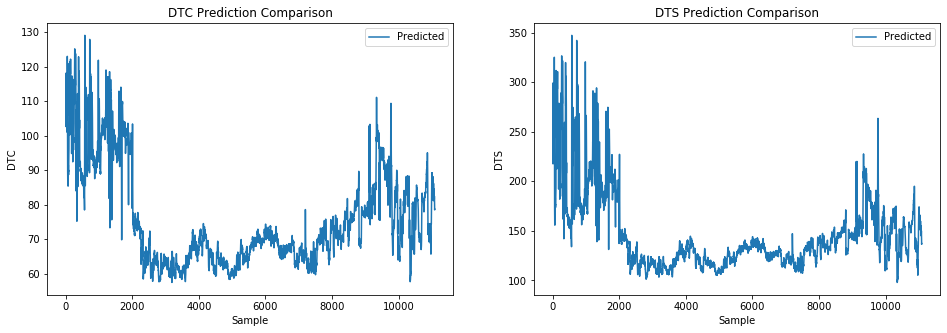

,DTC,DTS
0,109.889473,257.940857
1,111.571526,265.087524
2,112.631287,271.567688
3,112.556679,271.971436
4,110.713371,263.577942


In [6]:
# read test data
df_test = pd.read_csv('test.csv')
print('Raw testing data')
display(df_test)

# data cleaning
df_test = df_test.replace(['-999', -999], np.nan)
df_test.dropna(inplace=True)

# feature selection
df_test.drop(['CAL'], axis=1, inplace=True)
print('Cleaned training data')
display(df_test)

# run the prediction
X_test = df_test.values.reshape((df_test.shape[0], 1, n_features))
well2_predict = model.predict(X_test)

# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

# export results to csv
output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
output_result.to_csv(path_or_buf='./Rocket_Team_submission_2.csv', index=False)
output_result.head()

## 6. Summary
### 6.1. Batch size
The training performance is finished with a batch size of 16 and 21 epochs. As told by the competition committee, the training set is combined from 3 different wells. It would be better to avoid mixing samples from different training wells in a batch, as the long-term dependencies of LSTM are sensitive to spatial information of wells. One way of setting the batch size is to find the highest common factor of the number of samples among all the training wells.
### 6.2. Overfitting
Overfitting might be a problem, as the model training is only stopped once the MAE stops decreasing. In order to build a more solid model, a better protocol would be splitting the data into two sets: one for training and one for validation. In this situation, two of the three wells can be used as the traing set, and the other well can be held as the validation set. The validation set would be very useful to evaluate the performance of the model training and thus to mitigate the overfitting issue.
### 6.3. Other models
Due to limited time, only LSTM and bidirectional LSTM were tested for this competition. Other RNN methods would be worthy of investigation in furture work. Depth information, an indicator of the gap in well logs, can help analyze the spatial resolution of data and the selection of models. Furthermore, it can be incorporated to the inputs of physics-constrained RNN models. Unfortunately, this information is unavailable. 

## 7. References
- N. Pham, & X. Wu. (2019). Missing sonic log prediction using convolutional long short-term memory. Society of Exploration Geophysicists.
- Y. Chen and D. Zhang. (2020). Physics-Constrained Deep Learning of Geomechanical Logs. IEEE Transactions on Geoscience and Remote Sensing.